# Post-Training Quantization (PTQ) for Indonesian Sentiment Analysis Model

## Research Overview

**Model**: `mdhugol/indonesia-bert-sentiment-classification`  
**Objective**: Analyze the impact of quantization (FP32 → FP16 → INT8) on model size, inference speed, and prediction quality for Indonesian sentiment classification.

### Research Questions
1. How much model size reduction can be achieved through different quantization methods?
2. What is the impact on inference latency for each method?
3. Does quantization affect prediction accuracy and confidence?

---

## Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Model Loading](#2-model-loading)
3. [Baseline Evaluation (FP32)](#3-baseline-evaluation-fp32)
4. [Half-Precision (FP16)](#4-half-precision-fp16)
5. [Dynamic Quantization (INT8)](#5-dynamic-quantization-int8)
6. [Comparative Analysis](#6-comparative-analysis)
7. [Statistical Evaluation](#7-statistical-evaluation)
8. [Results Visualization](#8-results-visualization)
9. [Conclusions](#9-conclusions)

## 1. Environment Setup <a id="1-environment-setup"></a>

In [1]:
# Install required dependencies (run once)
!pip install torch transformers numpy pandas scipy matplotlib seaborn


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: C:\Users\kowlin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import time
import json
import copy
import warnings
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

C:\Users\kowlin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 2.7.0+cpu
CUDA Available: False
Device: cpu


In [ ]:
CONFIG = {
    "model_id": "mdhugol/indonesia-bert-sentiment-classification",
    "labels": {0: "POSITIVE", 1: "NEUTRAL", 2: "NEGATIVE"},
    
    # 
    "quantization_dtype": torch.qint8,
    "target_layers": {torch.nn.Linear},
    
    "num_inference_runs": 50,  # Predict kalimat berturut turut supaya dapatin latency yang akurat 
    "warmup_runs": 5,          # prediksi awal ga diitung
    
    "output_dir": "./outputs",
    "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S")
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)

print("Configuration loaded successfully.")
print(f"Output directory: {os.path.abspath(CONFIG['output_dir'])}")

Configuration loaded successfully.
Output directory: c:\BINUS\COOLYEAH\model-quantization-sentiment-analysis\quantization-ptq\src\standard-quantization\outputs


## 2. Model Loading <a id="2-model-loading"></a>

In [ ]:
print(f"Loading model: {CONFIG['model_id']}")
print("="*60)

tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_id"])
model_fp32 = AutoModelForSequenceClassification.from_pretrained(CONFIG["model_id"])

model_fp32.eval()

print(f"\n✓ Model loaded successfully")
print(f"  - Architecture: {model_fp32.config.model_type}")
print(f"  - Hidden Size: {model_fp32.config.hidden_size}")
print(f"  - Num Labels: {model_fp32.config.num_labels}")
print(f"  - Vocab Size: {model_fp32.config.vocab_size}")

Loading model: mdhugol/indonesia-bert-sentiment-classification


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 296.32it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: mdhugol/indonesia-bert-sentiment-classification
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



✓ Model loaded successfully
  - Architecture: bert
  - Hidden Size: 768
  - Num Labels: 3
  - Vocab Size: 50000


In [ ]:
# checkup modelnya siap dipake, semakin banyak trainable semakin bagus
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model_fp32)

print("\n" + "="*60)
print("MODEL PARAMETER SUMMARY")
print("="*60)
print(f"Total Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters:    {total_params - trainable_params:,}")


MODEL PARAMETER SUMMARY
Total Parameters:     124,443,651
Trainable Parameters: 124,443,651
Frozen Parameters:    0


## 3. Baseline Evaluation (FP32) <a id="3-baseline-evaluation-fp32"></a>

In [ ]:
TEST_SAMPLES = [
    # Positive sentiments
    {"text": "Produk ini sangat bagus dan berkualitas tinggi!", "expected": "POSITIVE"},
    {"text": "Pelayanan yang luar biasa, sangat memuaskan.", "expected": "POSITIVE"},
    {"text": "Saya sangat senang dengan pembelian ini.", "expected": "POSITIVE"},
    
    # Negative sentiments
    {"text": "Pelayanan toko ini sangat lambat dan mengecewakan.", "expected": "NEGATIVE"},
    {"text": "Kualitas produk buruk, tidak sesuai ekspektasi.", "expected": "NEGATIVE"},
    {"text": "Pengiriman sangat lama dan barang rusak.", "expected": "NEGATIVE"},
    
    # Neutral sentiments
    {"text": "Toko ini buka dari jam 9 pagi sampai jam 9 malam.", "expected": "NEUTRAL"},
    {"text": "Produk tersedia dalam berbagai warna.", "expected": "NEUTRAL"},
    {"text": "Harga produk ini adalah Rp 50.000.", "expected": "NEUTRAL"},
]

print(f"Prepared {len(TEST_SAMPLES)} test samples:")
print(f"  - Positive: {sum(1 for s in TEST_SAMPLES if s['expected'] == 'POSITIVE')}")
print(f"  - Negative: {sum(1 for s in TEST_SAMPLES if s['expected'] == 'NEGATIVE')}")
print(f"  - Neutral: {sum(1 for s in TEST_SAMPLES if s['expected'] == 'NEUTRAL')}")

Prepared 9 test samples:
  - Positive: 3
  - Negative: 3
  - Neutral: 3


In [ ]:
def predict(model, text, tokenizer=tokenizer, labels=CONFIG["labels"], use_fp16=False):
    """
    Perform sentiment prediction on input text.
    
    Args:
        model: PyTorch model for classification
        text: Input text string
        tokenizer: Tokenizer for the model
        labels: Label mapping dictionary
        use_fp16: Whether to use half-precision inputs
    
    Returns:
        dict: Contains prediction label, confidence, probabilities, and inference time
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    if use_fp16:
        inputs = {k: v.half() if v.dtype == torch.float32 else v for k, v in inputs.items()}
    
    start_time = time.perf_counter()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.perf_counter()
    
    logits = outputs.logits.float()  # Convert back to float for softmax
    probabilities = torch.softmax(logits, dim=1)[0]
    predicted_class_id = logits.argmax().item()
    confidence = probabilities[predicted_class_id].item()
    
    return {
        "label": labels[predicted_class_id],
        "class_id": predicted_class_id,
        "confidence": confidence,
        "probabilities": {labels[i]: prob.item() for i, prob in enumerate(probabilities)},
        "inference_time": end_time - start_time
    }

test_result = predict(model_fp32, "Ini adalah tes.")
print("Prediction function tested successfully.")
print(f"Sample result: {test_result['label']} (confidence: {test_result['confidence']:.4f})")

Prediction function tested successfully.
Sample result: NEUTRAL (confidence: 0.9821)


In [ ]:
def evaluate_model(model, samples, num_runs=CONFIG["num_inference_runs"], warmup=CONFIG["warmup_runs"], use_fp16=False):
    """
    Comprehensive model evaluation with statistical analysis.
    
    Args:
        model: PyTorch model
        samples: List of test samples
        num_runs: Number of inference runs for latency measurement
        warmup: Number of warmup runs
        use_fp16: Whether to use half-precision inputs
    
    Returns:
        dict: Evaluation results including predictions and timing statistics
    """
    results = {
        "predictions": [],
        "latencies": [],
        "accuracy": 0,
        "avg_confidence": 0,
    }
    
    correct = 0
    total_confidence = 0
    
    for sample in samples:
        for _ in range(warmup):
            _ = predict(model, sample["text"], use_fp16=use_fp16)
        
        sample_latencies = []
        for _ in range(num_runs):
            pred = predict(model, sample["text"], use_fp16=use_fp16)
            sample_latencies.append(pred["inference_time"])
        
        final_pred = predict(model, sample["text"], use_fp16=use_fp16)
        
        results["predictions"].append({
            "text": sample["text"],
            "expected": sample["expected"],
            "predicted": final_pred["label"],
            "confidence": final_pred["confidence"],
            "probabilities": final_pred["probabilities"],
            "avg_latency": np.mean(sample_latencies),
            "std_latency": np.std(sample_latencies)
        })
        
        results["latencies"].extend(sample_latencies)
        
        if final_pred["label"] == sample["expected"]:
            correct += 1
        total_confidence += final_pred["confidence"]
    
    results["accuracy"] = correct / len(samples)
    results["avg_confidence"] = total_confidence / len(samples)
    results["latency_stats"] = {
        "mean": np.mean(results["latencies"]),
        "std": np.std(results["latencies"]),
        "min": np.min(results["latencies"]),
        "max": np.max(results["latencies"]),
        "median": np.median(results["latencies"])
    }
    
    return results

print("Evaluation function defined.")

Evaluation function defined.


In [9]:
print("="*60)
print("BASELINE EVALUATION (FP32 Model)")
print("="*60)
print(f"Running {CONFIG['num_inference_runs']} inference iterations per sample...")
print(f"Warmup runs: {CONFIG['warmup_runs']}\n")

fp32_results = evaluate_model(model_fp32, TEST_SAMPLES)

print("\n" + "-"*60)
print("BASELINE RESULTS SUMMARY")
print("-"*60)
print(f"Accuracy:         {fp32_results['accuracy']*100:.2f}%")
print(f"Avg Confidence:   {fp32_results['avg_confidence']*100:.2f}%")
print(f"\nLatency Statistics:")
print(f"  Mean:   {fp32_results['latency_stats']['mean']*1000:.2f} ms")
print(f"  Std:    {fp32_results['latency_stats']['std']*1000:.2f} ms")
print(f"  Median: {fp32_results['latency_stats']['median']*1000:.2f} ms")
print(f"  Min:    {fp32_results['latency_stats']['min']*1000:.2f} ms")
print(f"  Max:    {fp32_results['latency_stats']['max']*1000:.2f} ms")

BASELINE EVALUATION (FP32 Model)
Running 50 inference iterations per sample...
Warmup runs: 5


------------------------------------------------------------
BASELINE RESULTS SUMMARY
------------------------------------------------------------
Accuracy:         100.00%
Avg Confidence:   97.45%

Latency Statistics:
  Mean:   88.93 ms
  Std:    189.69 ms
  Median: 49.15 ms
  Min:    36.08 ms
  Max:    2486.67 ms


In [10]:
# Save FP32 model and measure size
fp32_path = os.path.join(CONFIG["output_dir"], "model_fp32.pth")
torch.save(model_fp32.state_dict(), fp32_path)
fp32_size_mb = os.path.getsize(fp32_path) / (1024 * 1024)

print(f"\n✓ FP32 model saved: {fp32_path}")
print(f"  Model Size: {fp32_size_mb:.2f} MB")


✓ FP32 model saved: ./outputs\model_fp32.pth
  Model Size: 474.79 MB


## 4. Half-Precision (FP16) <a id="4-half-precision-fp16"></a>

In [11]:
print("="*60)
print("HALF-PRECISION CONVERSION (FP16)")
print("="*60)
print("Converting FP32 model to FP16 (half-precision)...\n")

# Create FP16 model
model_fp16 = copy.deepcopy(model_fp32)
model_fp16 = model_fp16.half()  # Convert to FP16
model_fp16.eval()

print("✓ FP16 model created successfully")

HALF-PRECISION CONVERSION (FP16)
Converting FP32 model to FP16 (half-precision)...

✓ FP16 model created successfully


In [ ]:
fp16_path = os.path.join(CONFIG["output_dir"], "model_fp16.pth")
torch.save(model_fp16.state_dict(), fp16_path)
fp16_size_mb = os.path.getsize(fp16_path) / (1024 * 1024)

print(f"✓ FP16 model saved: {fp16_path}")
print(f"  Model Size: {fp16_size_mb:.2f} MB")
print(f"  Size Reduction: {(1 - fp16_size_mb/fp32_size_mb)*100:.2f}%")

✓ FP16 model saved: ./outputs\model_fp16.pth
  Model Size: 237.43 MB
  Size Reduction: 49.99%


In [13]:
print("="*60)
print("FP16 MODEL EVALUATION")
print("="*60)
print(f"Running {CONFIG['num_inference_runs']} inference iterations per sample...\n")

fp16_results = evaluate_model(model_fp16, TEST_SAMPLES, use_fp16=True)

print("\n" + "-"*60)
print("FP16 RESULTS SUMMARY")
print("-"*60)
print(f"Accuracy:         {fp16_results['accuracy']*100:.2f}%")
print(f"Avg Confidence:   {fp16_results['avg_confidence']*100:.2f}%")
print(f"\nLatency Statistics:")
print(f"  Mean:   {fp16_results['latency_stats']['mean']*1000:.2f} ms")
print(f"  Std:    {fp16_results['latency_stats']['std']*1000:.2f} ms")
print(f"  Median: {fp16_results['latency_stats']['median']*1000:.2f} ms")
print(f"  Min:    {fp16_results['latency_stats']['min']*1000:.2f} ms")
print(f"  Max:    {fp16_results['latency_stats']['max']*1000:.2f} ms")

FP16 MODEL EVALUATION
Running 50 inference iterations per sample...


------------------------------------------------------------
FP16 RESULTS SUMMARY
------------------------------------------------------------
Accuracy:         100.00%
Avg Confidence:   97.45%

Latency Statistics:
  Mean:   139.82 ms
  Std:    212.95 ms
  Median: 83.50 ms
  Min:    70.27 ms
  Max:    2680.29 ms


## 5. Dynamic Quantization (INT8) <a id="5-dynamic-quantization-int8"></a>

In [ ]:
print("="*60)
print("APPLYING DYNAMIC QUANTIZATION")
print("="*60)
print(f"Target Layers: {CONFIG['target_layers']}")
print(f"Target Dtype:  {CONFIG['quantization_dtype']}")
print()

quantization_start = time.perf_counter()
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32,
    CONFIG["target_layers"],
    dtype=CONFIG["quantization_dtype"]
)
quantization_time = time.perf_counter() - quantization_start

print(f"✓ Quantization completed in {quantization_time:.2f} seconds")

APPLYING DYNAMIC QUANTIZATION
Target Layers: {<class 'torch.nn.modules.linear.Linear'>}
Target Dtype:  torch.qint8

✓ Quantization completed in 1.40 seconds


In [15]:
# Save INT8 model and measure size
int8_path = os.path.join(CONFIG["output_dir"], "model_int8.pth")
torch.save(model_int8.state_dict(), int8_path)
int8_size_mb = os.path.getsize(int8_path) / (1024 * 1024)

print(f"✓ INT8 model saved: {int8_path}")
print(f"  Model Size: {int8_size_mb:.2f} MB")
print(f"  Size Reduction: {(1 - int8_size_mb/fp32_size_mb)*100:.2f}%")

✓ INT8 model saved: ./outputs\model_int8.pth
  Model Size: 230.15 MB
  Size Reduction: 51.53%


In [16]:
print("="*60)
print("QUANTIZED MODEL EVALUATION (INT8)")
print("="*60)
print(f"Running {CONFIG['num_inference_runs']} inference iterations per sample...\n")

int8_results = evaluate_model(model_int8, TEST_SAMPLES)

print("\n" + "-"*60)
print("INT8 RESULTS SUMMARY")
print("-"*60)
print(f"Accuracy:         {int8_results['accuracy']*100:.2f}%")
print(f"Avg Confidence:   {int8_results['avg_confidence']*100:.2f}%")
print(f"\nLatency Statistics:")
print(f"  Mean:   {int8_results['latency_stats']['mean']*1000:.2f} ms")
print(f"  Std:    {int8_results['latency_stats']['std']*1000:.2f} ms")
print(f"  Median: {int8_results['latency_stats']['median']*1000:.2f} ms")
print(f"  Min:    {int8_results['latency_stats']['min']*1000:.2f} ms")
print(f"  Max:    {int8_results['latency_stats']['max']*1000:.2f} ms")

QUANTIZED MODEL EVALUATION (INT8)
Running 50 inference iterations per sample...


------------------------------------------------------------
INT8 RESULTS SUMMARY
------------------------------------------------------------
Accuracy:         100.00%
Avg Confidence:   97.66%

Latency Statistics:
  Mean:   56.50 ms
  Std:    61.54 ms
  Median: 45.91 ms
  Min:    34.87 ms
  Max:    745.03 ms


## 6. Comparative Analysis <a id="6-comparative-analysis"></a>

In [ ]:
comparison_data = {
    "Metric": [
        "Model Size (MB)",
        "Accuracy (%)",
        "Avg Confidence (%)",
        "Mean Latency (ms)",
        "Median Latency (ms)",
        "Std Latency (ms)"
    ],
    "FP32 (Baseline)": [
        f"{fp32_size_mb:.2f}",
        f"{fp32_results['accuracy']*100:.2f}",
        f"{fp32_results['avg_confidence']*100:.2f}",
        f"{fp32_results['latency_stats']['mean']*1000:.2f}",
        f"{fp32_results['latency_stats']['median']*1000:.2f}",
        f"{fp32_results['latency_stats']['std']*1000:.2f}"
    ],
    "FP16 (Half)": [
        f"{fp16_size_mb:.2f}",
        f"{fp16_results['accuracy']*100:.2f}",
        f"{fp16_results['avg_confidence']*100:.2f}",
        f"{fp16_results['latency_stats']['mean']*1000:.2f}",
        f"{fp16_results['latency_stats']['median']*1000:.2f}",
        f"{fp16_results['latency_stats']['std']*1000:.2f}"
    ],
    "INT8 (Quantized)": [
        f"{int8_size_mb:.2f}",
        f"{int8_results['accuracy']*100:.2f}",
        f"{int8_results['avg_confidence']*100:.2f}",
        f"{int8_results['latency_stats']['mean']*1000:.2f}",
        f"{int8_results['latency_stats']['median']*1000:.2f}",
        f"{int8_results['latency_stats']['std']*1000:.2f}"
    ],
    "FP16 vs FP32": [
        f"{(1 - fp16_size_mb/fp32_size_mb)*100:+.2f}%",
        f"{(fp16_results['accuracy'] - fp32_results['accuracy'])*100:+.2f}%",
        f"{(fp16_results['avg_confidence'] - fp32_results['avg_confidence'])*100:+.2f}%",
        f"{((fp16_results['latency_stats']['mean'] - fp32_results['latency_stats']['mean'])/fp32_results['latency_stats']['mean'])*100:+.2f}%",
        f"{((fp16_results['latency_stats']['median'] - fp32_results['latency_stats']['median'])/fp32_results['latency_stats']['median'])*100:+.2f}%",
        "N/A"
    ],
    "INT8 vs FP32": [
        f"{(1 - int8_size_mb/fp32_size_mb)*100:+.2f}%",
        f"{(int8_results['accuracy'] - fp32_results['accuracy'])*100:+.2f}%",
        f"{(int8_results['avg_confidence'] - fp32_results['avg_confidence'])*100:+.2f}%",
        f"{((int8_results['latency_stats']['mean'] - fp32_results['latency_stats']['mean'])/fp32_results['latency_stats']['mean'])*100:+.2f}%",
        f"{((int8_results['latency_stats']['median'] - fp32_results['latency_stats']['median'])/fp32_results['latency_stats']['median'])*100:+.2f}%",
        "N/A"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("QUANTIZATION COMPARISON SUMMARY (FP32 vs FP16 vs INT8)")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)


QUANTIZATION COMPARISON SUMMARY (FP32 vs FP16 vs INT8)
             Metric FP32 (Baseline) FP16 (Half) INT8 (Quantized) FP16 vs FP32 INT8 vs FP32
    Model Size (MB)          474.79      237.43           230.15      +49.99%      +51.53%
       Accuracy (%)          100.00      100.00           100.00       +0.00%       +0.00%
 Avg Confidence (%)           97.45       97.45            97.66       +0.00%       +0.21%
  Mean Latency (ms)           88.93      139.82            56.50      +57.22%      -36.47%
Median Latency (ms)           49.15       83.50            45.91      +69.90%       -6.58%
   Std Latency (ms)          189.69      212.95            61.54          N/A          N/A


In [ ]:
print("\n" + "="*120)
print("DETAILED PREDICTION COMPARISON (FP32 vs FP16 vs INT8)")
print("="*120)

prediction_comparison = []
for i, (fp32_pred, fp16_pred, int8_pred) in enumerate(zip(fp32_results["predictions"], fp16_results["predictions"], int8_results["predictions"])):
    fp16_match = "✓" if fp32_pred["predicted"] == fp16_pred["predicted"] else "✗"
    int8_match = "✓" if fp32_pred["predicted"] == int8_pred["predicted"] else "✗"
    prediction_comparison.append({
        "#": i+1,
        "Text": fp32_pred["text"][:35] + "...",
        "Expected": fp32_pred["expected"],
        "FP32": fp32_pred["predicted"],
        "FP32%": f"{fp32_pred['confidence']*100:.1f}%",
        "FP16": fp16_pred["predicted"],
        "FP16%": f"{fp16_pred['confidence']*100:.1f}%",
        "FP16=FP32": fp16_match,
        "INT8": int8_pred["predicted"],
        "INT8%": f"{int8_pred['confidence']*100:.1f}%",
        "INT8=FP32": int8_match
    })

df_predictions = pd.DataFrame(prediction_comparison)
print(df_predictions.to_string(index=False))

fp16_mismatches = sum(1 for p in prediction_comparison if p["FP16=FP32"] == "✗")
int8_mismatches = sum(1 for p in prediction_comparison if p["INT8=FP32"] == "✗")
print(f"\nFP16 vs FP32 Consistency: {len(prediction_comparison) - fp16_mismatches}/{len(prediction_comparison)} ({(1-fp16_mismatches/len(prediction_comparison))*100:.1f}%)")
print(f"INT8 vs FP32 Consistency: {len(prediction_comparison) - int8_mismatches}/{len(prediction_comparison)} ({(1-int8_mismatches/len(prediction_comparison))*100:.1f}%)")


DETAILED PREDICTION COMPARISON (FP32 vs FP16 vs INT8)
 #                                   Text Expected     FP32 FP32%     FP16 FP16% FP16=FP32     INT8 INT8% INT8=FP32
 1 Produk ini sangat bagus dan berkual... POSITIVE POSITIVE 99.0% POSITIVE 99.0%         ✓ POSITIVE 99.0%         ✓
 2 Pelayanan yang luar biasa, sangat m... POSITIVE POSITIVE 99.5% POSITIVE 99.5%         ✓ POSITIVE 99.5%         ✓
 3 Saya sangat senang dengan pembelian... POSITIVE POSITIVE 93.1% POSITIVE 93.1%         ✓ POSITIVE 94.5%         ✓
 4 Pelayanan toko ini sangat lambat da... NEGATIVE NEGATIVE 99.7% NEGATIVE 99.7%         ✓ NEGATIVE 99.7%         ✓
 5 Kualitas produk buruk, tidak sesuai... NEGATIVE NEGATIVE 99.7% NEGATIVE 99.7%         ✓ NEGATIVE 99.7%         ✓
 6 Pengiriman sangat lama dan barang r... NEGATIVE NEGATIVE 98.8% NEGATIVE 98.8%         ✓ NEGATIVE 98.8%         ✓
 7 Toko ini buka dari jam 9 pagi sampa...  NEUTRAL  NEUTRAL 95.8%  NEUTRAL 95.8%         ✓  NEUTRAL 96.3%         ✓
 8 Produk tersedi

## 7. Statistical Evaluation <a id="7-statistical-evaluation"></a>

In [ ]:
from scipy import stats

print("="*60)
print("STATISTICAL ANALYSIS")
print("="*60)

# FP16 vs FP32 Latency comparison
t_stat_fp16, p_value_fp16 = stats.ttest_ind(fp32_results["latencies"], fp16_results["latencies"])

print("\n1. FP16 vs FP32 Latency Comparison (Independent t-test)")
print("-"*40)
print(f"   FP32 Mean Latency: {np.mean(fp32_results['latencies'])*1000:.4f} ms")
print(f"   FP16 Mean Latency: {np.mean(fp16_results['latencies'])*1000:.4f} ms")
print(f"   t-statistic: {t_stat_fp16:.4f}")
print(f"   p-value: {p_value_fp16:.6f}")
print(f"   Significant (p < 0.05): {'Yes' if p_value_fp16 < 0.05 else 'No'}")

# INT8 vs FP32 Latency comparison
t_stat_int8, p_value_int8 = stats.ttest_ind(fp32_results["latencies"], int8_results["latencies"])

print("\n2. INT8 vs FP32 Latency Comparison (Independent t-test)")
print("-"*40)
print(f"   FP32 Mean Latency: {np.mean(fp32_results['latencies'])*1000:.4f} ms")
print(f"   INT8 Mean Latency: {np.mean(int8_results['latencies'])*1000:.4f} ms")
print(f"   t-statistic: {t_stat_int8:.4f}")
print(f"   p-value: {p_value_int8:.6f}")
print(f"   Significant (p < 0.05): {'Yes' if p_value_int8 < 0.05 else 'No'}")

# Effect size (Cohen's d) for INT8
pooled_std = np.sqrt(((len(fp32_results['latencies'])-1)*np.std(fp32_results['latencies'])**2 + 
                      (len(int8_results['latencies'])-1)*np.std(int8_results['latencies'])**2) /
                     (len(fp32_results['latencies']) + len(int8_results['latencies']) - 2))
cohens_d = (np.mean(fp32_results['latencies']) - np.mean(int8_results['latencies'])) / pooled_std

print(f"\n3. Effect Size (Cohen's d for INT8)")
print("-"*40)
print(f"   Cohen's d: {cohens_d:.4f}")
effect_interpretation = "negligible" if abs(cohens_d) < 0.2 else "small" if abs(cohens_d) < 0.5 else "medium" if abs(cohens_d) < 0.8 else "large"
print(f"   Interpretation: {effect_interpretation} effect")

# Confidence difference analysis
fp32_confidences = [p["confidence"] for p in fp32_results["predictions"]]
fp16_confidences = [p["confidence"] for p in fp16_results["predictions"]]
int8_confidences = [p["confidence"] for p in int8_results["predictions"]]

conf_t_stat_fp16, conf_p_value_fp16 = stats.ttest_rel(fp32_confidences, fp16_confidences)
conf_t_stat_int8, conf_p_value_int8 = stats.ttest_rel(fp32_confidences, int8_confidences)

print(f"\n4. Confidence Score Comparison (Paired t-test)")
print("-"*40)
print(f"   FP32 Mean Confidence: {np.mean(fp32_confidences)*100:.2f}%")
print(f"   FP16 Mean Confidence: {np.mean(fp16_confidences)*100:.2f}%")
print(f"   INT8 Mean Confidence: {np.mean(int8_confidences)*100:.2f}%")
print(f"   FP16 vs FP32 p-value: {conf_p_value_fp16:.6f}")
print(f"   INT8 vs FP32 p-value: {conf_p_value_int8:.6f}")

STATISTICAL ANALYSIS

1. FP16 vs FP32 Latency Comparison (Independent t-test)
----------------------------------------
   FP32 Mean Latency: 88.9319 ms
   FP16 Mean Latency: 139.8184 ms
   t-statistic: -3.7809
   p-value: 0.000167
   Significant (p < 0.05): Yes

2. INT8 vs FP32 Latency Comparison (Independent t-test)
----------------------------------------
   FP32 Mean Latency: 88.9319 ms
   INT8 Mean Latency: 56.4960 ms
   t-statistic: 3.4465
   p-value: 0.000594
   Significant (p < 0.05): Yes

3. Effect Size (Cohen's d for INT8)
----------------------------------------
   Cohen's d: 0.2300
   Interpretation: small effect

4. Confidence Score Comparison (Paired t-test)
----------------------------------------
   FP32 Mean Confidence: 97.45%
   FP16 Mean Confidence: 97.45%
   INT8 Mean Confidence: 97.66%
   FP16 vs FP32 p-value: 0.405017
   INT8 vs FP32 p-value: 0.238436


## 8. Results Visualization <a id="8-results-visualization"></a>

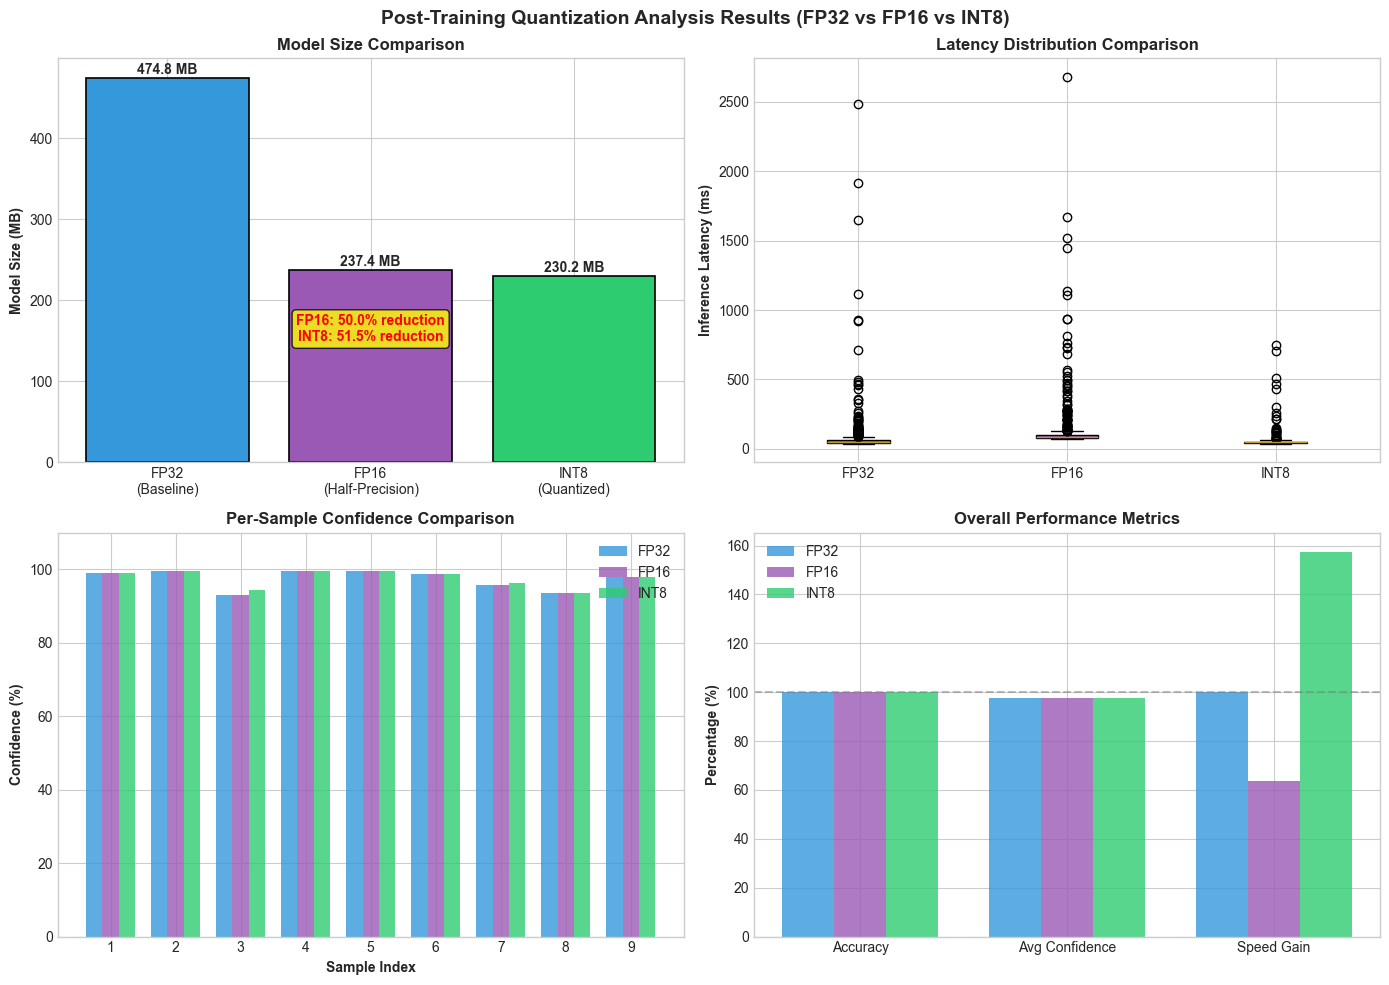


✓ Visualization saved to: ./outputs\quantization_analysis.png


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Post-Training Quantization Analysis Results (FP32 vs FP16 vs INT8)', fontsize=14, fontweight='bold')

# 1. Model Size Comparison
ax1 = axes[0, 0]
sizes = [fp32_size_mb, fp16_size_mb, int8_size_mb]
labels = ['FP32\n(Baseline)', 'FP16\n(Half-Precision)', 'INT8\n(Quantized)']
colors = ['#3498db', '#9b59b6', '#2ecc71']
bars = ax1.bar(labels, sizes, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Model Size (MB)', fontweight='bold')
ax1.set_title('Model Size Comparison', fontweight='bold')
for bar, size in zip(bars, sizes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{size:.1f} MB', ha='center', va='bottom', fontweight='bold')
fp16_reduction = (1 - fp16_size_mb/fp32_size_mb) * 100
int8_reduction = (1 - int8_size_mb/fp32_size_mb) * 100
ax1.annotate(f'FP16: {fp16_reduction:.1f}% reduction\nINT8: {int8_reduction:.1f}% reduction', 
             xy=(0.5, 0.3), xycoords='axes fraction',
             fontsize=10, ha='center', color='red', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# 2. Latency Distribution
ax2 = axes[0, 1]
latency_data = [np.array(fp32_results['latencies'])*1000, 
                np.array(fp16_results['latencies'])*1000,
                np.array(int8_results['latencies'])*1000]
bp = ax2.boxplot(latency_data, labels=['FP32', 'FP16', 'INT8'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#9b59b6')
bp['boxes'][2].set_facecolor('#2ecc71')
ax2.set_ylabel('Inference Latency (ms)', fontweight='bold')
ax2.set_title('Latency Distribution Comparison', fontweight='bold')

# 3. Confidence Scores
ax3 = axes[1, 0]
x = np.arange(len(TEST_SAMPLES))
width = 0.25
ax3.bar(x - width, [p['confidence']*100 for p in fp32_results['predictions']], 
        width, label='FP32', color='#3498db', alpha=0.8)
ax3.bar(x, [p['confidence']*100 for p in fp16_results['predictions']], 
        width, label='FP16', color='#9b59b6', alpha=0.8)
ax3.bar(x + width, [p['confidence']*100 for p in int8_results['predictions']], 
        width, label='INT8', color='#2ecc71', alpha=0.8)
ax3.set_xlabel('Sample Index', fontweight='bold')
ax3.set_ylabel('Confidence (%)', fontweight='bold')
ax3.set_title('Per-Sample Confidence Comparison', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([str(i+1) for i in x])
ax3.legend()
ax3.set_ylim(0, 110)

# 4. Performance Summary
ax4 = axes[1, 1]
metrics = ['Accuracy', 'Avg Confidence', 'Speed Gain']
fp32_vals = [fp32_results['accuracy']*100, fp32_results['avg_confidence']*100, 100]
speedup_fp16 = (fp32_results['latency_stats']['mean'] / fp16_results['latency_stats']['mean']) * 100 if fp16_results['latency_stats']['mean'] > 0 else 100
speedup_int8 = (fp32_results['latency_stats']['mean'] / int8_results['latency_stats']['mean']) * 100 if int8_results['latency_stats']['mean'] > 0 else 100
fp16_vals = [fp16_results['accuracy']*100, fp16_results['avg_confidence']*100, speedup_fp16]
int8_vals = [int8_results['accuracy']*100, int8_results['avg_confidence']*100, speedup_int8]

x = np.arange(len(metrics))
ax4.bar(x - width, fp32_vals, width, label='FP32', color='#3498db', alpha=0.8)
ax4.bar(x, fp16_vals, width, label='FP16', color='#9b59b6', alpha=0.8)
ax4.bar(x + width, int8_vals, width, label='INT8', color='#2ecc71', alpha=0.8)
ax4.set_ylabel('Percentage (%)', fontweight='bold')
ax4.set_title('Overall Performance Metrics', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'quantization_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {os.path.join(CONFIG['output_dir'], 'quantization_analysis.png')}")

## 9. Conclusions <a id="9-conclusions"></a>

In [23]:
print("="*80)
print("RESEARCH CONCLUSIONS")
print("="*80)

print(f"""
EXPERIMENT SUMMARY
{'='*60}
Model:          {CONFIG['model_id']}
Methods:        FP32 (Baseline), FP16 (Half-Precision), INT8 (Dynamic Quantization)
Target Layers:  Linear Layers
Test Samples:   {len(TEST_SAMPLES)}
Inference Runs: {CONFIG['num_inference_runs']} per sample

KEY FINDINGS
{'='*60}
1. Model Size Reduction:
   - Original (FP32): {fp32_size_mb:.2f} MB
   - Half-Precision (FP16): {fp16_size_mb:.2f} MB ({(1 - fp16_size_mb/fp32_size_mb)*100:.2f}% reduction)
   - Quantized (INT8): {int8_size_mb:.2f} MB ({(1 - int8_size_mb/fp32_size_mb)*100:.2f}% reduction)

2. Accuracy Impact:
   - FP32 Accuracy: {fp32_results['accuracy']*100:.2f}%
   - FP16 Accuracy: {fp16_results['accuracy']*100:.2f}% ({(fp16_results['accuracy'] - fp32_results['accuracy'])*100:+.2f}%)
   - INT8 Accuracy: {int8_results['accuracy']*100:.2f}% ({(int8_results['accuracy'] - fp32_results['accuracy'])*100:+.2f}%)

3. Inference Latency:
   - FP32 Mean: {fp32_results['latency_stats']['mean']*1000:.2f} ms
   - FP16 Mean: {fp16_results['latency_stats']['mean']*1000:.2f} ms ({(fp32_results['latency_stats']['mean']/fp16_results['latency_stats']['mean']):.2f}x speedup)
   - INT8 Mean: {int8_results['latency_stats']['mean']*1000:.2f} ms ({(fp32_results['latency_stats']['mean']/int8_results['latency_stats']['mean']):.2f}x speedup)

4. Prediction Consistency:
   - FP16 vs FP32: {len(TEST_SAMPLES) - fp16_mismatches}/{len(TEST_SAMPLES)} matches ({(1-fp16_mismatches/len(TEST_SAMPLES))*100:.1f}%)
   - INT8 vs FP32: {len(TEST_SAMPLES) - int8_mismatches}/{len(TEST_SAMPLES)} matches ({(1-int8_mismatches/len(TEST_SAMPLES))*100:.1f}%)

""")

RESEARCH CONCLUSIONS

EXPERIMENT SUMMARY
Model:          mdhugol/indonesia-bert-sentiment-classification
Methods:        FP32 (Baseline), FP16 (Half-Precision), INT8 (Dynamic Quantization)
Target Layers:  Linear Layers
Test Samples:   9
Inference Runs: 50 per sample

KEY FINDINGS
1. Model Size Reduction:
   - Original (FP32): 474.79 MB
   - Half-Precision (FP16): 237.43 MB (49.99% reduction)
   - Quantized (INT8): 230.15 MB (51.53% reduction)

2. Accuracy Impact:
   - FP32 Accuracy: 100.00%
   - FP16 Accuracy: 100.00% (+0.00%)
   - INT8 Accuracy: 100.00% (+0.00%)

3. Inference Latency:
   - FP32 Mean: 88.93 ms
   - FP16 Mean: 139.82 ms (0.64x speedup)
   - INT8 Mean: 56.50 ms (1.57x speedup)

4. Prediction Consistency:
   - FP16 vs FP32: 9/9 matches (100.0%)
   - INT8 vs FP32: 9/9 matches (100.0%)


